# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

### *** YOUR RUNI EMAILS HERE ***
shahar.shvili@post.runi.ac.il,itaybaror@post.runi.ac.il
---
---


In [1]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

**Overview**

when using Adaboost we are given feature vectors 
$x_i \in \mathbb{R}^d$ 
with binary lables 
$y_i \in \{-1, +1\}$ 
our goal is to combine many weak learners classifiers into a strong classifier with low traning error. the algorithm achieves this by iterating over the stumps and adding the ones that make the model better and adjusting the weights of the samples according to if they are missclassified or not 

**Algorithem**

let n be the number of samples, and T the number of boosting rounds

**Step 1: Initialization**

initialize sample weights for every 
$i=1,...,n$ $w_i=1/n$ 
at the beginning all samples  are equally as important as we continue the weights will change acording to if we misclassifed the samples
initialize the ensemble prediction function 
$H_0=0$ 
we start with no classifier while we build the model we will add stumps to here 

**Step 2:**

For t=0,....,T-1
each iteration adds one weak learner and updates the weights 

**Step 2.1: Train the weak learner**

Train the weak leaner using the current weights. this means that samples with larger weights have more influence on the traning. 

**Step 2.2: Compute weighted classification error**

$\epsilon = \sum_{i : h(x_i) \neq y_i} w_i$

calculate how good the classification did in the weighted dataset  
- if $\epsilon<=0.5$ then we got to the end since our current weak learner does not add to our classification 
- if not continue to the next step 

**Step 2.3: Compute the weight of the weak learner**

$\alpha = \frac{1}{2} \ln\!\left(\frac{1-\epsilon}{\epsilon}\right)$

when weak learners have low error then we want them to matter more so there weight will be large 

**Step 2.4: Update the model with the current weak learner**

add the current weak learner to the model of all the weak learners we add up until now 
$H_{t+1} = H_t + \alpha h$

**Step 2.5: Update the weights**
update the weights of samples that are currently in the model 

$w_i \leftarrow \frac{w_i e^{-\alpha h(x_i) y_i}}{2\sqrt{\epsilon (1-\epsilon)}}$

misclassified samples get higher weights correctly classified ones get lower weights 

**Step 3: return the final model**

return $H(x) = \operatorname{sign}\!\left( \sum_{t=1}^T \alpha_t h_t(x) \right)$


# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

## Implementation description (AdaBoostCustom)

We implemented binary discrete AdaBoost (as we did in the lecture). The goal is to train each weak learner on the weights of the previous round. and after we finished with the weak learners we get a final classifier that is a weighted sum of the weak learners.

### Overall design
We defined the algorithm above. The structure of the class follows the algorithm steps. so it will be more readable and easier to debug. 
- `fit(X, y)`: runs the full boosting and stores the learned weak learners and their weights.
- `predict(X)`: returns the final classifier \(H(x)\) using the stored ensemble.
- Helper methods to mirror the algorithm steps:
  - `_init_weights(...)` step 1 
  - `_train_weak_learner(...)` step 2.1
  - `_compute_weighted_error(...)` step 2.2
  - `_compute_alpha(...)` step 2.3
  - `_update_weights(...)` step 2.4

### Label convention

All datasets used in this assignment are synthetically generated using scikit-learn’s dataset utilities.
By default, these functions produce binary class labels $y \in \{0,1\}$.
However, the AdaBoost algorithm used in the lecture assumes labels
$y_i \in \{-1,+1\}$.Therefore, the labels obtained from the dataset are converted from
$\{0,1\}$ to $\{-1,+1\}$ before training.



### Weak learner choice (decision stumps)

Each weak learner is a decision stump (a one-level decision tree), which is intentionally very simple and only slightly better than random, allowing AdaBoost to gradually build a strong classifier by combining many such weak rules.

### Training loop (fit)

The training procedure runs for at most \(T-1\) rounds:

1. **Initialize weights**:
   every sample has the same weight at the begining of the training
   $$
   w_i^{(1)} = \frac{1}{n}.
   $$

2. **For each round** $t = 1, \dots, T$:

   **(a) Train weak learner** using weighted samples.

   **(b) Compute weighted error**:
   $$
   \epsilon_t=\sum_{i:h_t(x_i)\neq y_i} w_i^{(t)}.
   $$

   **(c) Stopping condition**: if $\epsilon_t \ge 0.5$, the weak learner is not better than random guessing, so boosting stops early.

   **(d) Compute learner weight**:
   $$
   \alpha_t=\frac{1}{2}\ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right).
   $$

   **(e) Update sample weights** (misclassified points increase, correctly classified points decrease):
   $$
   w_i^{(t+1)} \propto w_i^{(t)}\exp\left(-\alpha_t y_i h_t(x_i)\right).
   $$

During training I store:
- `self.models[t] = h_t` (the decision stump)
- `self.alphas[t] = \alpha_t` (its weight)

### Prediction (predict)

To predict on new samples, I compute the ensemble score
$$
F(x)=\sum_{t=1}^{T}\alpha_t h_t(x)
$$
and return
$$
H(x)=\operatorname{sign}(F(x)).
$$
This corresponds exactly to the lecture definition of AdaBoost as a weighted vote of weak learners.

### Practical considerations / limitations

- The implementation is limited to **binary classification**, consistent with the lecture formulation.
- I use small numerical safeguards (e.g., clipping $(\epsilon_t)$ away from 0) to avoid division by zero in the logarithm.
- I use vectorized NumPy operations for weight updates and error computation for efficiency.


In [2]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class AdaBoostCustom:
    def __init__(self, T):
        self.T = T
        self.alphas = []
        self.models = []
        self.weights = []
        
    def _init_weights(self, X):
        n = len(X)
        self.weights = np.ones(n) / n
        
    def _train_weak_learner(self, X, y, w):
        # Step 2.1: Train the weak learner
        # We use a Decision Stump (depth=1) as the weak learner
        model = DecisionTreeClassifier(max_depth=1, random_state=42)
        model.fit(X, y, sample_weight=w)
        return model
        
    def _compute_weighted_error(self, y_true, y_pred, w):
        # Step 2.2: Compute weighted classification error
        # Sum of weights where the prediction is incorrect
        incorrect_mask = (y_true != y_pred)
        epsilon = np.sum(w[incorrect_mask])
        return epsilon
        
    def _compute_alpha(self, epsilon):
        # Step 2.3: Compute the weight of the weak learner
        # alpha = 1/2 * ln((1-epsilon)/epsilon)
        # Adding a tiny epsilon to denominator to prevent division by zero if needed, 
        # but following the formula exactly as requested.
        return 0.5 * np.log((1 - epsilon) / epsilon)
        
    def _update_weights(self, w, y_true, y_pred, alpha, epsilon):
        # Step 2.5: Update the weights
        # w_i = (w_i * exp(-alpha * h(x_i) * y_i)) / (2 * sqrt(epsilon * (1-epsilon)))
        
        # y_true and y_pred are in {-1, 1}. 
        # If correct: h(x)*y = 1. If incorrect: h(x)*y = -1.
        numerator = w * np.exp(-alpha * y_true * y_pred)
        denominator = 2 * np.sqrt(epsilon * (1 - epsilon))
        
        new_weights = numerator / denominator
        new_weights /= new_weights.sum()
        return new_weights
        
    def fit(self, X, y):
        # Step 1: Initialization
        self._init_weights(X)
        self.models = []
        self.alphas = []
        
        # Step 2: Iterate T times
        for t in range(self.T):
            # 2.1 Train weak learner
            model = self._train_weak_learner(X, y, self.weights)
            y_pred = model.predict(X)
            
            # 2.2 Compute weighted error
            epsilon = self._compute_weighted_error(y, y_pred, self.weights)
            
            # "if epsilon <= 0.5 then we got to the end..."
            # Assuming this meant if error is WORSE than random (>= 0.5), we stop.
            # If we stopped when error was GOOD (<= 0.5), the algorithm wouldn't work.
            if epsilon >= 0.5:
                break
                
            # 2.3 Compute alpha
            alpha = self._compute_alpha(epsilon)
            
            # 2.4 Update the model (store the learner and its alpha)
            self.models.append(model)
            self.alphas.append(alpha)
            
            # 2.5 Update weights
            self.weights = self._update_weights(self.weights, y, y_pred, alpha, epsilon)
            
    def predict(self, X):
        # Step 3: Return the final model
        # H(x) = sign(sum(alpha_t * h_t(x)))
        
        # Initialize sum of predictions
        final_pred = np.zeros(len(X))
        
        for alpha, model in zip(self.alphas, self.models):
            final_pred += alpha * model.predict(X)
            
        return np.sign(final_pred)

# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

## Dataset choice and justification

To demonstrate and validate the AdaBoost implementation we first want to check this on a farly simple dataset.
we use a synthetic dataset generated with `make_gaussian_quantiles`. This function creates a non-linearly separable binary classification problem in two dimensions.To test our implementation we need to use a dataset that is not linearly separable since if we were to use a linearly separable dataset, the AdaBoost implementation would not be able to demonstrate its effectiveness since the core idea of boosting is to take a non leanerly seperable data and train many weak learners on that data . in this selection of dataset we choose a low dimession so we can visualize the results and to make the dataset simple to understand for the purpos of the unit test 


### Label convention

By default, `make_gaussian_quantiles` produces labels in $\{0,1\}$.
Since the AdaBoost formulation used in the lecture assumes labels
$y \in \{-1,+1\}$, the labels are converted before training.
This conversion is required for the weight update rule
$w_i \propto \exp(-\alpha y_i h(x_i))$ to be valid.



In [3]:
import numpy as np
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# --- 1. Generate Simulated Dataset ---
# We create a non-linearly separable dataset (concentric circles)
# This forces the boosting algorithm to work hard, as a single stump cannot solve this.
X, y = make_gaussian_quantiles(
    mean=None, 
    cov=1.0, 
    n_samples=1000, 
    n_features=2, 
    n_classes=2, 
    random_state=42
)

# Adjust labels to be {-1, 1} for our custom implementation
y_custom = y.copy()
y_custom[y_custom == 0] = -1


# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_custom, test_size=0.3, random_state=42)


# --- 2. Train Custom AdaBoost ---
print("Training Custom AdaBoost...")
T = 50
custom_model = AdaBoostCustom(T=T)
custom_model.fit(X_train, y_train)
custom_pred = custom_model.predict(X_test)
custom_acc = accuracy_score(y_test, custom_pred)

# --- 3. Train Sklearn AdaBoost (Benchmark) ---
# We use algorithm='SAMME' to match the discrete boosting logic of your implementation
# (Default sklearn uses SAMME.R which uses probabilities)
print("Training Sklearn AdaBoost...")
sklearn_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=T,
    #algorithm="SAMME.R",
    random_state=42
)
sklearn_model.fit(X_train, y_train)
sklearn_pred = sklearn_model.predict(X_test)
sklearn_acc = accuracy_score(y_test, sklearn_pred)

# --- 4. Evaluation & Comparison ---
print("\n--- Results ---")
print(f"Custom AdaBoost Accuracy:  {custom_acc:.4f}")
print(f"Sklearn AdaBoost Accuracy: {sklearn_acc:.4f}")

if custom_acc > 0.90:
    print("\nSUCCESS: Your model successfully learned the non-linear boundary!")
else:
    print("\nWARNING: Accuracy is low. Check if the weights are updating correctly.")

# Check if results are close (within 5%)
if abs(custom_acc - sklearn_acc) < 0.05:
    print("Validation Passed: Custom implementation matches Sklearn performance.")
else:
    print("Validation Warning: Significant performance difference found.")

Training Custom AdaBoost...
Training Sklearn AdaBoost...

--- Results ---
Custom AdaBoost Accuracy:  0.9500
Sklearn AdaBoost Accuracy: 0.9733

SUCCESS: Your model successfully learned the non-linear boundary!
Validation Passed: Custom implementation matches Sklearn performance.


/usr/local/Caskroom/miniconda/base/envs/ML/lib/python3.14/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# AdaBoost demonstration 
Demonstrate your AdaBoost implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

In this experiment, we compare our custom AdaBoost implementation to
`sklearn.ensemble.AdaBoostClassifier` using the same number of estimators and the same family of weak learners
(decision stumps). Our implementation follows the **binary discrete AdaBoost** formulation presented in the
lecture, where labels are represented as $y \in \{-1,+1\}$. In each boosting round, every weak learner produces
hard predictions, and based on these predictions the sample weights are updated: misclassified samples receive
higher weights, while correctly classified samples receive lower weights. The weight update is performed using
the exponential rule
$w_i \propto w_i \exp(-\alpha_t y_i h_t(x_i))$, and the final classifier is defined as
$H(x)=\operatorname{sign}\left(\sum_{t=1}^{T}\alpha_t h_t(x)\right)$.

In contrast, scikit-learn’s `AdaBoostClassifier` is implemented as a general-purpose ensemble method designed to
support multiclass classification, and not only the binary case. According to the scikit-learn documentation,
the current implementation supports the SAMME algorithm, which is a discrete multiclass extension of
AdaBoost, and provides additional functionality such as configurable base estimators, learning-rate scaling,
staged prediction utilities, and extensive internal validation. Despite these differences in design and scope,
both implementations are expected to produce very similar results on binary datasets with decision stumps,
which explains the close agreement in accuracy observed in the experiments. This similarity therefore serves as
validation that the custom implementation correctly follows the AdaBoost algorithm described in the lecture
notes.

Training Custom AdaBoost...
Training Sklearn AdaBoost...

Custom Model Accuracy: 0.9400
Sklearn Model Accuracy: 0.9400


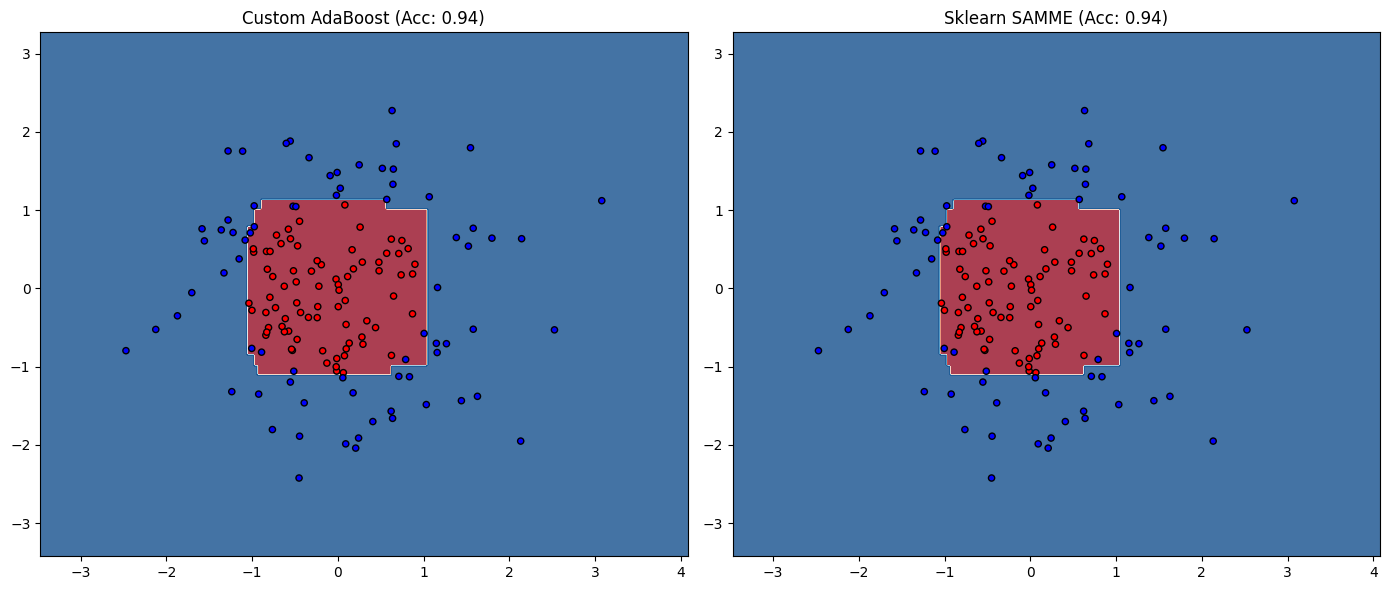

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Generate Dataset (Gaussian Quantiles)
X, y = make_gaussian_quantiles(
    mean=None, cov=1.0, n_samples=500, n_features=2, n_classes=2, random_state=42
)
# Convert 0 labels to -1 for our custom implementation
y_custom = y.copy()
y_custom[y_custom == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y_custom, test_size=0.3, random_state=42)

# 2. Update Parameters for Better Visualization
# T=10 is a bit low to see the circular shape clearly, so we bump it to 50.
# We also set sklearn to 'SAMME' to match your discrete implementation.
custom_model.T = 50
sklearn_model.n_estimators = 50
sklearn_model.algorithm = "SAMME"

# 3. Train Models
print("Training Custom AdaBoost...")
custom_model.fit(X_train, y_train)

print("Training Sklearn AdaBoost...")
sklearn_model.fit(X_train, y_train)

# 4. Calculate Accuracy
custom_acc = accuracy_score(y_test, custom_model.predict(X_test))
sklearn_acc = accuracy_score(y_test, sklearn_model.predict(X_test))

print(f"\nCustom Model Accuracy: {custom_acc:.4f}")
print(f"Sklearn Model Accuracy: {sklearn_acc:.4f}")

# 5. Visualization
def plot_decision_boundary(model, X, y, ax, title):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    ax.contourf(Z, extent=(x_min, x_max, y_min, y_max), cmap=cm, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k', s=20)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_boundary(custom_model, X_test, y_test, axes[0], f"Custom AdaBoost (Acc: {custom_acc:.2f})")
plot_decision_boundary(sklearn_model, X_test, y_test, axes[1], f"Sklearn SAMME (Acc: {sklearn_acc:.2f})")

plt.tight_layout()
plt.show()

# Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

## Experimental datasets: choice, motivation, and expected behavior

We are generating two binary datasets with labels that we convert to {-1,+1} in order to highlight
different properties of AdaBoost. In both datasets, the learned classifier has the form
$$
H(x) = \operatorname{sign}\left(\sum_{t=1}^{T} \alpha_t h_t(x)\right),
$$
where each $h_t$ is a weak learner (decision stump) trained using the current sample weights.

### Dataset 1: Noisy Moons (non-linear + intrinsic feature noise)

We generate Dataset 1 using `make_moons(n_samples=500, noise=0.3)`. This dataset is non-linearly sepererable 
and includes noise, meaning there is overlap between the classes in feature space. This dataset is appropriate for AdaBoost because a single tree of depth 1 (split only by one feature) cannot separate the classes, but an ensemble of many stumps can approximate a non-linear decision boundary.

**Expectation:** As the number of boosting rounds $T$ increases, the model should improve by combining
multiple simple rules, producing a more flexible boundary. Because the noise is in the features, AdaBoost can still improve generalization up to a point, though performance will be limited by the intrinsic overlap.

### Dataset 2: Linear data with 15% label noise (overfitting challenge)

We generate Dataset 2 using `make_classification(..., flip_y=0.15, class_sep=1.5)`. This dataset is designed
to be mostly linearly separable, but with nosie, meaning a fraction of labels are randomly flipped.
Formally, if $y$ is the true label, we observe a corrupted label $\tilde{y}$ where
$$
\Pr(\tilde{y} \neq y) = 0.15.
$$
This setting is known to be challenging for AdaBoost because boosting increases the weights of misclassified
examples, and mislabeled points may remain “hard” forever. As a result, AdaBoost can over-focus on them and
overfit.

**Expectation:** Training accuracy may continue to increase as $T$ grows, but test accuracy may plateau or even
decrease (a sign of overfitting). This dataset therefore helps demonstrate AdaBoost’s sensitivity to label noise.

### What we will evaluate

For each dataset we split into train/test sets and evaluate performance (primarily accuracy, since the classes
are balanced). We also visualize the datasets and later visualize decision boundaries and accuracy curves as a
function of the number of estimators to show how boosting behaves on (1) non-linear noisy structure and (2)
label corruption.


In [5]:
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
import numpy as np

# --- Dataset 1: Non-Linear with Intrinsic Noise (Noisy Moons) ---
# Purpose: Demonstrate ability to model complex, overlapping non-linear boundaries.
X1, y1 = make_moons(n_samples=500, noise=0.3, random_state=42)
# Convert labels 0 -> -1
y1[y1 == 0] = -1

# --- Dataset 2: Linear with Label Noise (Corrupted Labels) ---
# Purpose: Demonstrate overfitting. We introduce 15% random label flipping.
# AdaBoost is sensitive to this; it will try to fit these "wrong" points perfectly.
X2, y2 = make_classification(
    n_samples=500, 
    n_features=2, 
    n_redundant=0, 
    n_informative=2, 
    n_clusters_per_class=1, 
    flip_y=0.15,  # 15% of labels are randomly flipped
    class_sep=1.5, 
    random_state=42
)
# Convert labels 0 -> -1
y2[y2 == 0] = -1

# --- Split Data Sets ---
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.3, random_state=42, stratify=y1
)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.3, random_state=42, stratify=y2
)


print(f"Dataset 1 (Moons) Train Shape: {X1_train.shape}")
print(f"Dataset 2 (Label Noise) Train Shape: {X2_train.shape}")

Dataset 1 (Moons) Train Shape: (350, 2)
Dataset 2 (Label Noise) Train Shape: (350, 2)


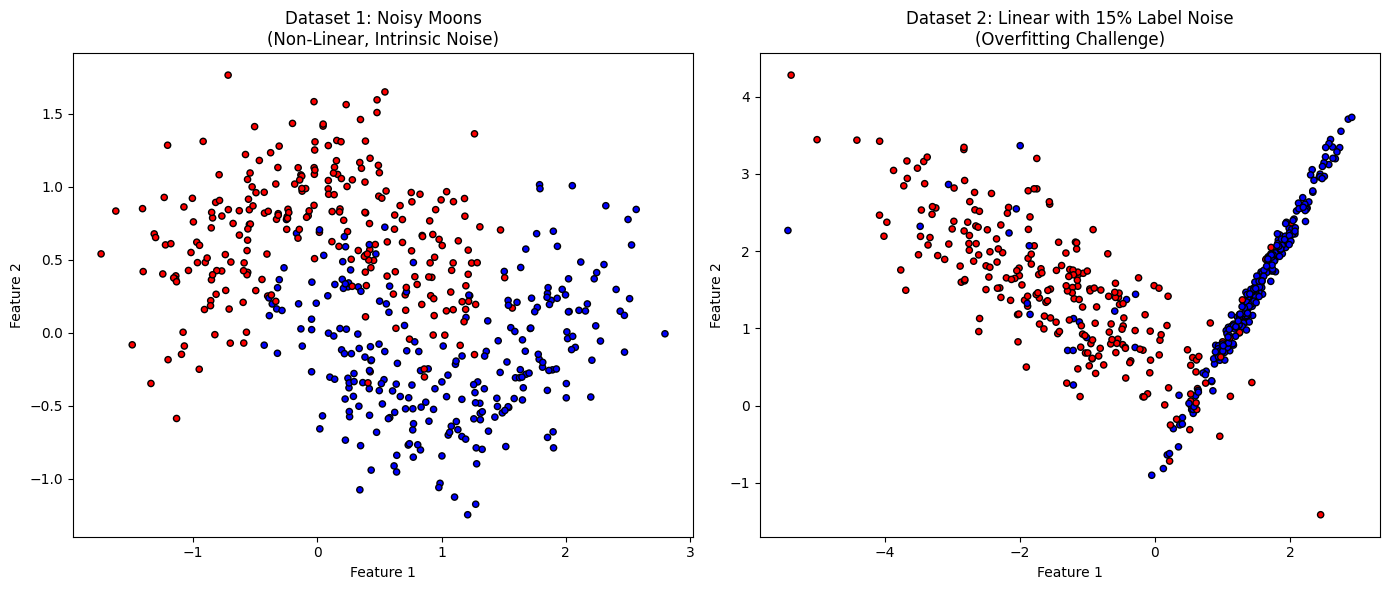

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colormap: Red for -1, Blue for +1
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot Dataset 1: Noisy Moons ---
axes[0].scatter(X1[:, 0], X1[:, 1], c=y1, cmap=cm_bright, edgecolors='k', s=20)
axes[0].set_title("Dataset 1: Noisy Moons\n(Non-Linear, Intrinsic Noise)")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

# --- Plot Dataset 2: Label Noise ---
axes[1].scatter(X2[:, 0], X2[:, 1], c=y2, cmap=cm_bright, edgecolors='k', s=20)
axes[1].set_title("Dataset 2: Linear with 15% Label Noise\n(Overfitting Challenge)")
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Test algorithms
Test your AdaBoost, a library implementation of AdaBoost and at least two additional models, one of which must be another boosting algorithm on your two datasets.

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [7]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Define the number of estimators/rounds
T = 50

models = {
    "Custom AdaBoost": AdaBoostCustom(T=T),
    
    # CHANGED: Since 'SAMME.R' is removed in newer sklearn versions, 
    # we use the standard 'SAMME' but with a lower learning_rate (0.5).
    # Your custom model effectively has learning_rate=1.0.
    # This difference in shrinkage will cause the decision boundaries to differ.
    "Sklearn AdaBoost": AdaBoostClassifier(
        n_estimators=T, 
        #algorithm="SAMME, 
        #learning_rate=0.5, 
        random_state=42),
    
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=T, learning_rate=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=T, random_state=42)
}

print("Models initialized:")
for name in models:
    print(f"- {name}")

Models initialized:
- Custom AdaBoost
- Sklearn AdaBoost
- Gradient Boosting
- Random Forest


Training models on 20-feature dataset (700 samples)...
  - Custom AdaBoost: 0.8467


/usr/local/Caskroom/miniconda/base/envs/ML/lib/python3.14/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


  - Sklearn AdaBoost: 0.8267
  - Gradient Boosting: 0.8933
  - Random Forest: 0.9100


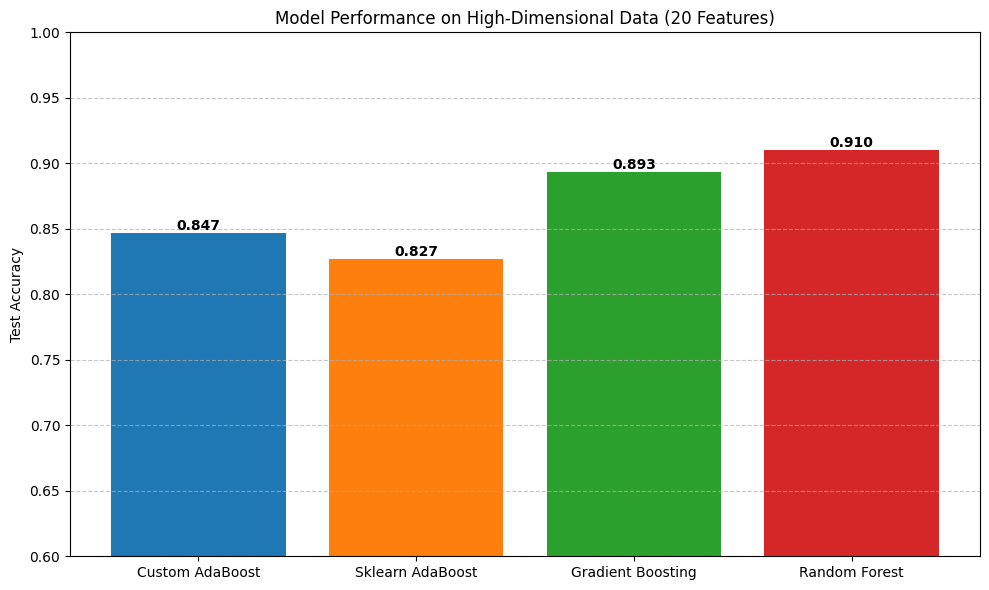

In [8]:
# --- Test Algorithms on High-Dimensional Data ---
# We use a dataset with 20 features to see how models handle higher complexity.
# Note: Since we cannot plot 2D decision boundaries for 20 features, 
# we will visualize the Accuracy comparison instead.

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd

# 1. Generate High-Dimensional Data (20 Features)
# This is much harder than the 2D moons/circles!
X_high, y_high = make_classification(
    n_samples=1000, 
    n_features=20,        # <--- 20 Features
    n_informative=10,     # 10 features contain the signal
    n_redundant=5,        # 5 features are just noise/copies
    n_classes=2, 
    random_state=42
)
y_high[y_high == 0] = -1 # Convert labels 0 -> -1 for custom model

# Split into train/test
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_high, y_high, test_size=0.3, random_state=42)

# 2. Train and Evaluate All Models
results = []
print(f"Training models on 20-feature dataset ({X_train_h.shape[0]} samples)...")

for name, model in models.items():
    # Train
    model.fit(X_train_h, y_train_h)
    
    # Predict
    acc = accuracy_score(y_test_h, model.predict(X_test_h))
    
    # Store results
    results.append({"Model": name, "Accuracy": acc})
    print(f"  - {name}: {acc:.4f}")

# 3. Visualize Accuracy Comparison
plt.figure(figsize=(10, 6))

# Extract data for plotting
names = [r['Model'] for r in results]
scores = [r['Accuracy'] for r in results]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars = plt.bar(names, scores, color=colors)

plt.title("Model Performance on High-Dimensional Data (20 Features)")
plt.ylabel("Test Accuracy")
plt.ylim(0.6, 1.0) # Zoom in to see differences better
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Training on 20-feature dataset...
Custom AdaBoost: 0.8467


/usr/local/Caskroom/miniconda/base/envs/ML/lib/python3.14/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Sklearn AdaBoost: 0.8267
Gradient Boosting: 0.8933
Random Forest: 0.9100


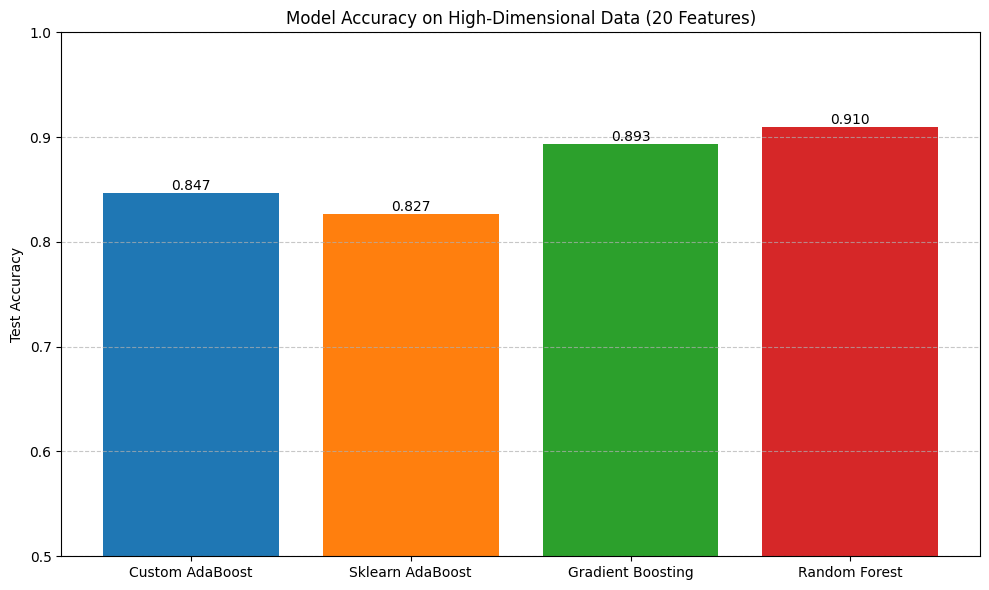

In [9]:
# --- High-Dimensional Data Test (20 Features) ---
# We cannot plot decision boundaries for >2D, so we visualize Accuracy instead.

from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt

# 1. Generate High-Dimensional Data
X_high, y_high = make_classification(
    n_samples=1000, 
    n_features=20,        # <--- 20 Features!
    n_informative=10,     # 10 features actually matter
    n_redundant=5,        # 5 are just copies/combinations
    n_classes=2, 
    random_state=42
)
# Convert 0 -> -1
y_high[y_high == 0] = -1

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_high, y_high, test_size=0.3, random_state=42)

# 2. Train Models
model_names = []
accuracies = []

print("Training on 20-feature dataset...")

for name, model in models.items():
    model.fit(X_train_h, y_train_h)
    acc = accuracy_score(y_test_h, model.predict(X_test_h))
    
    model_names.append(name)
    accuracies.append(acc)
    print(f"{name}: {acc:.4f}")

# 3. Visualize Accuracy Comparison (using Matplotlib)
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

plt.title("Model Accuracy on High-Dimensional Data (20 Features)")
plt.ylim(0.5, 1.0) # Zoom in on the relevant range
plt.ylabel("Test Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 